In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
DATADIR = "../input/LANL-Earthquake-Prediction"

print(os.listdir(DATADIR))

# Any results you write to the current directory are saved as output.

dev_mode = True

['test', 'sample_submission.csv', 'train.csv']


In [2]:
df = pd.read_csv(os.path.join(DATADIR, 'train.csv'),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [3]:
import lanl_generator_py as lanl_generator

classes = lanl_generator.get_lanl_classes()
df_segments = lanl_generator.classify_segments(df, classes)
folder = lanl_generator.FoldGenerator(df_segments)

In [4]:
class FeatureGenerator(object):
    QUANTILES = [0.05, 0.95]
    QUANTILE_MEAN = [-2.1, 11.2]
    QUANTILE_STD = [2.3, 2.3]

    FREQUENCY_MEAN = -2.4
    FREQUENCY_STD = 0.9

    STD_CLIP_MAX = 8

    FREQUENCIES = [191, 198, 190, 211]

    def shape(self):
        return (1 + len(self.QUANTILES) + len(self.FREQUENCIES), )

    def feature_names(self):
        names = ['s_std']
        for q in self.QUANTILES:
            names.append('q{0}'.format(q))
        for f in self.FREQUENCIES:
            names.append('f{0}m'.format(f))
        return names

    @classmethod
    def fft_analysis(cls, y_data):
        yf = np.fft.fft(y_data)
        # positive
        yf = yf[:, : y_data.size // 2]
        # top frequencies
        yf = yf[:, 64:320]
        yf = yf / y_data.size
        epsilon = 1.0e-9
        y_fft = np.log(np.abs(yf) + epsilon)

        # normalize
        y_fft = (y_fft - cls.FREQUENCY_MEAN) / cls.FREQUENCY_STD
        return y_fft


    def generate(self, df: pd.DataFrame, predict=False):
        values = df['acoustic_data'].values

        qdata = [np.quantile(values, q) for q in self.QUANTILES]
        def q_clip(q, i, sigma=1):
            m = self.QUANTILE_MEAN[i]
            s = self.QUANTILE_STD[i]
            return np.clip(q, m - sigma * s, m + sigma * s)
    
        qdata = [q_clip(q, i) for i, q in enumerate(qdata)]
        Q = np.array(qdata)
        
        y = values.reshape(100, 1_500)
        ys = np.std(y, axis=1)
        Sx = np.array([
            np.clip(np.mean(ys), None, self.STD_CLIP_MAX),
        ])

        steps = 150_000 // 4096
        offset = 150_000 % 4096
        y = values[offset:].reshape(steps, 4096)
        F = self.fft_analysis(y)
        Fm = np.mean(F, axis=0)
        Fs = Fm[self.FREQUENCIES]
    
        X = np.concatenate([Sx, Q, Fs])
        
        if predict:
            return X
        y = df['time_to_failure'].iloc[-1]
        return X, np.array([y])

In [5]:
from tqdm.autonotebook import tqdm

def generate_data(gen):
    X_data = []
    Y_data = []
    for i in tqdm(range(len(gen))):
        x, y = gen[i]
        X_data.append(x)
        Y_data.append(y)

    return np.vstack(X_data), np.concatenate(Y_data)

train_indices, eval_indices = folder[0]
gen_train = lanl_generator.SegmentGenerator(
        df, FeatureGenerator(), train_indices, rand_offset=0)

X_train, Y_train = generate_data(gen_train)




/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
if dev_mode:
    gen_eval = lanl_generator.SegmentGenerator(
            df, FeatureGenerator(), eval_indices)
    X_eval, Y_eval = generate_data(gen_eval)

In [7]:
def vcorrcoef(X,y):
    """ Calculate the correlation coeficient between a matrix X and vector y.
    """
    Xm = np.mean(X, axis=0)
    ym = np.mean(y, axis=0)
    r_num = np.sum((X-Xm)*(y-ym),axis=0)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=0)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r


In [8]:
cr = vcorrcoef(X_train, Y_train)



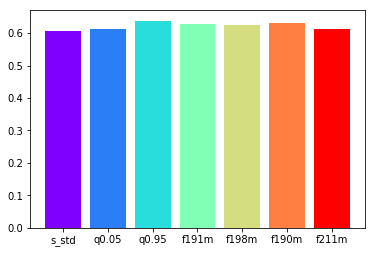

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots()
x = np.arange(0, cr.size)
colors = cm.rainbow(np.linspace(0, 1, cr.size))
ax.bar(x, np.abs(cr), color=colors)
ax.set_xticks(x)
ax.set_xticklabels(FeatureGenerator().feature_names())
plt.show()




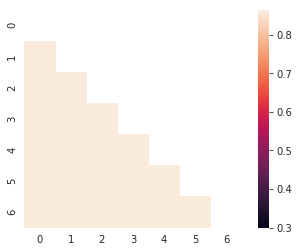

In [10]:
import seaborn as sns
corr = np.corrcoef(X_train, rowvar=False)
corr = np.abs(corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
plt.show()

In [11]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K

class range_initializer(keras.initializers.Initializer):
    def __init__(self, vmax = 0.0, vmean = 0.0):
        self.vmax = vmax
        self.vmean = vmean

    def get_config(self):
        return {'vmax': self.vmax, 'vmean': self.vmean}

    def __call__(self, shape, dtype=None, partition_info=None):
        if len(shape) != 2 or shape[1] != 1:
            raise ValueError('Expected shape (N, 1), got ', shape)
        return np.arange(shape[0])[:, np.newaxis] / shape[0] * self.vmax - self.vmean

def make_model():
    inp = Input(shape=FeatureGenerator().shape())
    r = Dense(16, activation='relu')(inp)
    out = Dense(1, name='ttf',
                # kernel_initializer=range_initializer(16.0, 5.6),
                bias_initializer=keras.initializers.Constant(5.6)
                )(r)
    model = Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mae', metrics=['mae'])
    return model

K.clear_session()
tf.set_random_seed(42)
model = make_model()
model.summary()
model.save('model-features.h5')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                128       
_________________________________________________________________
ttf (Dense)                  (None, 1)                 17        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [12]:
ckpt_filepath = 'sel-features.{0}.ckpt.hdf'

if dev_mode:
    fold = 0
    cb_checkpoint = keras.callbacks.ModelCheckpoint(
        ckpt_filepath.format(fold), monitor='val_mean_absolute_error', verbose=True,
        save_best_only=True, mode='min')
    cb_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


    train_indices, _ = folder[fold]
    gen_train = lanl_generator.SegmentGenerator(
        df, FeatureGenerator(), train_indices, rand_offset=50_000)
    history = model.fit_generator(
        gen_train, validation_data=(X_eval, Y_eval),
        callbacks=[cb_checkpoint, cb_stop],
        verbose=True,
        epochs=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
826/826 [==============================] - 0s 112us/sample - loss: 2.6079 - mean_absolute_error: 2.6078

Epoch 00001: val_mean_absolute_error improved from inf to 2.60777, saving model to sel-features.0.ckpt.hdf
106/106 [==============================] - 30s 279ms/step - loss: 2.8333 - mean_absolute_error: 2.8309 - val_loss: 2.6106 - val_mean_absolute_error: 2.6078
Epoch 2/50
826/826 [==============================] - 0s 52us/sample - loss: 2.3343 - mean_absolute_error: 2.3342

Epoch 00002: val_mean_absolute_error improved from 2.60777 to 2.33423, saving model to sel-features.0.ckpt.hdf
106/106 [==============================] - 29s 270ms/step - loss: 2.5253 - mean_absolute_error: 2.5234 - val_loss: 2.3365 - val_mean_absolute_error: 2.3342
Epoch 3/50
826/826 [==============================] - 0s 47us/sample - loss: 2.1718 - mean_absolute_error: 2.1717

Epoch 00003: val_mean_absolute_error improved from 2.33423 to 2.17170, savin

Epoch 23/50
826/826 [==============================] - 0s 48us/sample - loss: 2.0943 - mean_absolute_error: 2.0943

Epoch 00023: val_mean_absolute_error did not improve from 2.09384
106/106 [==============================] - 29s 278ms/step - loss: 2.1397 - mean_absolute_error: 2.1400 - val_loss: 2.0959 - val_mean_absolute_error: 2.0943
Epoch 24/50
826/826 [==============================] - 0s 47us/sample - loss: 2.0914 - mean_absolute_error: 2.0914

Epoch 00024: val_mean_absolute_error improved from 2.09384 to 2.09136, saving model to sel-features.0.ckpt.hdf
106/106 [==============================] - 29s 271ms/step - loss: 2.1320 - mean_absolute_error: 2.1374 - val_loss: 2.0931 - val_mean_absolute_error: 2.0914
Epoch 25/50
826/826 [==============================] - 0s 55us/sample - loss: 2.0923 - mean_absolute_error: 2.0923

Epoch 00025: val_mean_absolute_error did not improve from 2.09136
106/106 [==============================] - 29s 271ms/step - loss: 2.1291 - mean_absolute_error: 2

Epoch 46/50
826/826 [==============================] - 0s 45us/sample - loss: 2.0814 - mean_absolute_error: 2.0814

Epoch 00046: val_mean_absolute_error improved from 2.08184 to 2.08139, saving model to sel-features.0.ckpt.hdf
106/106 [==============================] - 28s 269ms/step - loss: 2.1369 - mean_absolute_error: 2.1368 - val_loss: 2.0829 - val_mean_absolute_error: 2.0814
Epoch 47/50
826/826 [==============================] - 0s 59us/sample - loss: 2.0876 - mean_absolute_error: 2.0875

Epoch 00047: val_mean_absolute_error did not improve from 2.08139
106/106 [==============================] - 29s 273ms/step - loss: 2.1262 - mean_absolute_error: 2.1297 - val_loss: 2.0889 - val_mean_absolute_error: 2.0875
Epoch 48/50
826/826 [==============================] - 0s 42us/sample - loss: 2.0845 - mean_absolute_error: 2.0845

Epoch 00048: val_mean_absolute_error did not improve from 2.08139
106/106 [==============================] - 28s 268ms/step - loss: 2.1344 - mean_absolute_error: 2

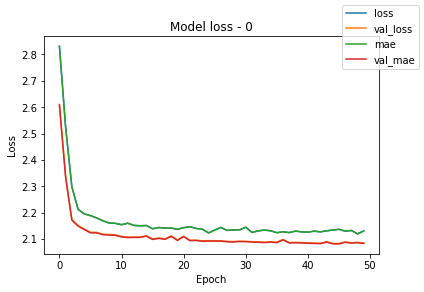

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_history(hist, fold):
    fig, ax1 = plt.subplots()
    ax1.plot(hist.history['loss'], label='loss')
    ax1.plot(hist.history['val_loss'], label='val_loss')
    ax1.set_title('Model loss - {0}'.format(fold))
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    if 'mean_absolute_error' in hist.history:
        ax1.plot(hist.history['mean_absolute_error'], label='mae')
        ax1.plot(hist.history['val_mean_absolute_error'], label='val_mae')
    fig.legend()
    plt.show()

show_history(history, 0)


In [14]:
def prediction_error(model, classes, X_eval, Y_eval):
    y_pred = model.predict(X_eval)
    serr = (y_pred - Y_eval).reshape(-1)
    
    err = np.abs(serr)
    bins = np.digitize(Y_eval, classes)
    hist = np.bincount(bins.reshape(-1), minlength=classes.size)
    errhist = np.zeros((classes.size))
    for e, b in zip(err, bins):
        errhist[b] += e
    errhist /= (hist + 1.0e-9)

    hdensity = hist / np.sum(hist)
    return serr, errhist, hdensity


  [0, 0.5) 3.8168917806294904 [0.5, 8.0) 1.465461793235696 [8.0, inf) 4.333065537345689
  [2.0, 4.0) 1.0659828493153338


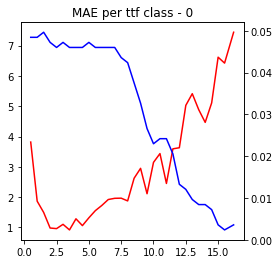

In [16]:
def show_measurements(measurements):
    serr, errhist, hdensity = measurements
    print(' ', '[0, 0.5)', np.mean(errhist[:1]),
          '[0.5, 8.0)', np.mean(errhist[1:16]),
          '[8.0, inf)', np.mean(errhist[16:]))
    print(' ', '[2.0, 4.0)', np.mean(errhist[4:8]))

def show_mae_distribution(ax1, classes, measurements, fold):
    _, errhist, hdensity = measurements
    ax1.set_title('MAE per ttf class - {0}'.format(fold))
    ax1.plot(classes, errhist, label='mae', c='r')
    ax2 = ax1.twinx()
    ax2.plot(classes, hdensity, label='density', c='b')


if dev_mode:
    measurements = prediction_error(model, classes, X_eval, Y_eval)
    show_measurements(measurements)

    fig, ax = plt.subplots(figsize=(4, 4), sharex=True, sharey=True)
    show_mae_distribution(ax, classes, measurements, 0)
    plt.show()

    